In [1]:
from IPython.display import HTML, display

def progress(value, max=100):
    return HTML("""
        <progress
            value='{value}'
            max='{max}',
            style='width: 75%'
        >
            {value}
        </progress>
    """.format(value=value, max=max))

In [2]:
def f1_loss_for_training(y_true, y_pred):

    tp = y_true * y_pred
    tp = K.sum(tp * y_pred) / (K.sum(y_pred) + K.epsilon())

    tn = (1-y_true) * (1-y_pred)
    tn = K.sum(tn * (1-y_pred)) / (K.sum(1-y_pred) + K.epsilon()) 

    fp = (1-y_true) * y_pred
    fp = K.sum(fp * y_pred) / (K.sum(y_pred)  + K.epsilon())

    fn = y_true * (1-y_pred)
    fn = K.sum(fn * (1-y_pred)) / (K.sum(1-y_pred) + K.epsilon()) 

    p = tp / (tp + fp + K.epsilon()) # Precision = tp / tp + fp
    r = tp / (tp + fn + K.epsilon()) # Recall = tp / (tp+fn)

    f1 = (2*p*r) / (p+r+K.epsilon())

    return 1 - f1

In [3]:
# TBD 1 : logger 추가
# TBD 2: flask github 참고, method, class, 파일의 맨 윗단 마다 pydoc 형식으로 달기
# TBD 3: 축약어를 자제할것 (특히 변수)

# tensorflow Module
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras import backend as keras_backend
from tensorflow.keras.layers import GaussianNoise
from tensorflow.keras.layers import Input, Concatenate
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Nadam
from tensorflow.keras.initializers import RandomNormal
from tensorflow.keras import losses

# python basic Module
import os
import sys
import types
from datetime import datetime
from shutil import copy
from pickle import dump, load

# math, image, plot Module
import numpy as np
import cv2
import matplotlib.pyplot as plt  # TBD

# email Module
import smtplib
from email.mime.text import MIMEText
from email.header import Header

from data_loader.medical_segmentation_data_loader import DataLoader

from gan_module.model import build_generator, build_discriminator
from gan_module.draw_images import ImageDrawer

# set GPU memory growth allocation
gpu_devices = tf.config.experimental.list_physical_devices("GPU")
for device in gpu_devices:
    tf.config.experimental.set_memory_growth(device, True)

"""
if you don't have nvidia-gpu, try plaidml! but it will works tensorflow 1.x.x
# pip install -U plaidml-keras
# plaidml-setup
"""
# use_plaidml = False
# if use_plaidml :
#     import plaidml.keras
#     plaidml.keras.install_backend()
#     os.environ["KERAS_BACKEND"] = "plaidml.keras.backend"


# class CaptchaDiscriminator
# captcha_generator = CaptchaGenerator()
# CaptchaGeneratorTrainer(captcha_generator, discriminator)
# class CaptchaGeneratorTrainer():
# class LearningRate():
# class Smtp()
# class Shape()
# class InputShape(Shape):
# class OutputShape(Shape):
# class Model():
#     def save():
#     def load():
# class Generator(Model) :
#     @override
#     def save():
#         super()
# class HyperParameter()


class CaptchaGenerator:
    def __init__(
        self,
        generator_power=32,
        discriminator_power=32,
        generator_learning_rate=1e-4,
        discriminator_learning_rate=1e-4,
        learning_rate_decay_rate_epoch=0.1,
        learning_rate_decay_rate_dynamic=0.1,
        find_init_epoch=150,
        find_error=False,
        temp_weights_path=".",
        draw_images=True,
    ):
        # smtp info
        self.smtp_host = "smtp.gmail.com"
        self.smtp_port = 465
        self.smtp_id = "rpa.manager0001@gmail.com"
        self.smtp_password = "!rpa.admin!23"
        self.smtp_to_addr = "tobeor3009@gmail.com"

        # Input shape
        self.img_rows = 512
        self.img_cols = 512
        self.input_channels = 3
        self.output_channels = 1
        self.input_img_shape = (
            self.img_rows, self.img_cols, self.input_channels)
        self.output_img_shape = (
            self.img_rows, self.img_cols, self.output_channels)
        # set parameter
        self.discriminator_training_switch_patience_count = None
        self.start_epoch = None
        self.history = [[], [], []]
        self.learning_rate_decay_rate_epoch = learning_rate_decay_rate_epoch
        self.learning_rate_decay_rate_dynamic = learning_rate_decay_rate_dynamic
        self.find_init_epoch = find_init_epoch
        self.find_error = find_error
        self.find_error_epoch = 30
        self.error_list = []
        self.temp_weights_path = temp_weights_path

        # Configure data loader
        self.dataset_name = "tumor"
        self.data_loader = DataLoader(
            dataset_name=self.dataset_name, img_res=(
                self.img_rows, self.img_cols)
        )
        self.loaded_data = self.data_loader.load_all(on_memory=True)
        self.loaded_data_len = self.data_loader.data_length
        self.loaded_data_index = np.arange(self.loaded_data_len)
        # Configure Image Drawer
        self.draw_images = draw_images
        self.image_drawer = ImageDrawer(
            dataset_name=self.dataset_name, data_loader=self.data_loader
        )
        # training parameters
        self.learning_schedule = [
            50,
            100,
            150,
            200,
            250,
            300,
            350,
            400,
            450,
            500,
            550
        ]
        self.discriminator_acc_previous = 0.5
        self.generator_loss_min = 100
        self.generator_loss_previous = 100
        self.generator_loss_max_previous = 1000
        self.generator_loss_max_min = 1000
        self.generator_loss_min_min = 1000
        self.weight_save_stack = False
        self.weight_stagnant_stack = 0
        self.look_on_for_generator_min_loss = False
        self.discriminator_learning = True
        self.learning_rate_decay_dynamic = 0
        self.training_end_stack = 0
        # Calculate output shape of D (PatchGAN)
        patch = int(self.img_rows / 2 ** 2)
        self.disc_patch = (patch, patch, 1)

        # Number of filters in the first layer of G and D
        self.generator_power = generator_power
        self.discriminator_power = discriminator_power
        self.generator_learning_rate = generator_learning_rate
        self.discriminator_learning_rate = discriminator_learning_rate
        generator_optimizer = Nadam(self.generator_learning_rate)
        discriminator_optimizer = Nadam(self.discriminator_learning_rate)

        # layer Component
        self.kernel_initializer = RandomNormal(mean=0.0, stddev=0.02)

        # Build and compile the discriminator
        self.discriminator = build_discriminator(
            input_img_shape=self.input_img_shape,
            output_img_shape=self.output_img_shape,
            discriminator_power=self.discriminator_power,
            kernel_initializer=self.kernel_initializer,
        )
        # self.discriminator = self.build_discriminator()
        # 'mse' or tf.keras.losses.Huber() tf.keras.losses.LogCosh()
        self.discriminator.compile(
            loss=tf.keras.losses.LogCosh(),
            optimizer=discriminator_optimizer,
            metrics=["accuracy"],
        )

        # -------------------------
        # Construct Computational
        #   Graph of Generator
        # -------------------------

        # Build the generator
        self.generator = build_generator(
            input_img_shape=self.input_img_shape,
            output_channels=self.output_channels,
            generator_power=self.generator_power,
            kernel_initializer=self.kernel_initializer,
        )

        # Input images and their conditioning images
        original_img = Input(shape=self.input_img_shape)
        masked_img = Input(shape=self.output_img_shape)
        # generate image from original_img for target masked_img
        model_masked_img = self.generator(original_img)

        # For the combined model we will only train the generator
        self.discriminator.trainable = False
        # Discriminators determines validity of translated images / condition pairs
        model_validity = self.discriminator([original_img, model_masked_img])
        # give score by
        # 1. how generator trick discriminator
        # 2. how generator's image same as real photo in pixel
        # 3. if you want change loss, see doc https://keras.io/api/losses/
        # 4. 'mse', 'mae', tf.keras.losses.LogCosh(),  tf.keras.losses.Huber()
        self.combined = Model(
            inputs=[original_img, masked_img],
            outputs=[model_validity, model_masked_img, model_masked_img],
        )
        self.combined.compile(
            loss=[
                tf.keras.losses.LogCosh(),
                tf.keras.losses.Huber(),
                f1_loss_for_training
            ],
            loss_weights=[1, 100, 0.5],
            optimizer=generator_optimizer
        )

    def train(self, epochs, batch_size=1, sample_interval=50):

        start_time = datetime.now()

        # Adversarial loss ground truths
        self.training_end_stack = 0
        self.batch_size = batch_size
        valid_patch = np.ones((self.batch_size,) +
                              self.disc_patch, dtype=np.float32)
        fake_patch = np.zeros((self.batch_size,) +
                              self.disc_patch, dtype=np.float32)
        self.discriminator_learning = True
        if self.discriminator_training_switch_patience_count:
            discriminator_training_switch_patience_count = self.discriminator_training_switch_patience_count
        else:
            discriminator_training_switch_patience_count = 0
        
        if self.start_epoch is None:
            self.start_epoch = 0
        if isinstance(self.loaded_data, types.GeneratorType):
            self.loaded_data = self.data_loader.load_all(on_memory=False)
        
        for epoch in range(self.start_epoch, epochs):
            batch_i = 0
            discriminator_acces = []
            generator_losses = []
            generator_loss_max_in_epoch = 0
            generator_loss_min_in_epoch = 1000
            generator_current_learning_rate = self.learning_rate_scheduler(
                self.generator_learning_rate
                * (2 ** (self.learning_rate_decay_dynamic)),
                epoch,
            )
            discriminator_current_learning_rate = self.learning_rate_scheduler(
                self.discriminator_learning_rate
                * (2 ** (self.learning_rate_decay_dynamic)),
                epoch,
            )
            if self.discriminator_acc_previous > 0.9:
                discriminator_current_learning_rate *= 0.5
            if (
                0.5 < self.discriminator_acc_previous
                and self.discriminator_acc_previous < 0.75
            ):
                discriminator_current_learning_rate *= 1.25
            if self.discriminator_acc_previous <= 0.5:
                discriminator_current_learning_rate *= 1.5
            keras_backend.set_value(
                self.combined.optimizer.learning_rate, generator_current_learning_rate
            )
            keras_backend.set_value(
                self.discriminator.optimizer.learning_rate,
                discriminator_current_learning_rate,
            )
            # shffle data 5 epoch term
            if epoch % 5 == 0 and not isinstance(self.loaded_data, types.GeneratorType):
                np.random.shuffle(self.loaded_data_index)
                self.loaded_data = [
                    self.loaded_data[i][self.loaded_data_index] for i in range(2)
                ]

            if epoch in self.learning_schedule or epoch == 10:
                self.discriminator_learning = True
                self.load_best_weights()

            while batch_i + self.batch_size <= self.loaded_data_len:
                original_img = self.loaded_data[0][batch_i: batch_i +
                                   self.batch_size]
                masked_img = self.loaded_data[1][batch_i: batch_i +
                                                 self.batch_size]

                # ---------------------
                #  Train Discriminator
                # ---------------------
                # Condition on B and generate a translated version
                model_masked_img = self.generator.predict_on_batch(
                    original_img)

                # forTest
                self.masked_img = masked_img
                self.original_img = original_img
                self.model_masked_img = model_masked_img
                self.valid_path = valid_patch
                self.fake_patch = fake_patch

                # Train the discriminators (target image = masked_img / generated_img = model_masked_img)
                if self.discriminator_learning:
                    discriminator_loss_for_man_made = self.discriminator.train_on_batch(
                        [original_img, masked_img], valid_patch
                    )
                    discriminator_loss_for_model_made = (
                        self.discriminator.train_on_batch(
                            [original_img, model_masked_img], fake_patch
                        )
                    )
                else:
                    discriminator_loss_for_man_made = self.discriminator.test_on_batch(
                        [original_img, masked_img], valid_patch
                    )
                    discriminator_loss_for_model_made = (
                        self.discriminator.test_on_batch(
                            [original_img, model_masked_img], fake_patch
                        )
                    )

                discriminator_loss = 0.5 * np.add(
                    discriminator_loss_for_man_made, discriminator_loss_for_model_made
                )
                # -----------------
                #  Train Generator
                # -----------------

                # Train the generators
                generator_loss = self.combined.train_on_batch(
                    [original_img, masked_img],
                    [valid_patch, masked_img, masked_img],
                )
                elapsed_time = datetime.now() - start_time
                if batch_i % sample_interval == 0:
                    # Plot the progress
                    print(
                        "[Epoch %d/%d] [Batch %d/%d] [D loss: %f, acc: %3d%%] [G loss: %f] time: %s"
                        % (
                            epoch,
                            epochs,
                            batch_i,
                            self.loaded_data_len,
                            discriminator_loss[0],
                            100 * discriminator_loss[1],
                            generator_loss[0],
                            elapsed_time,
                        )
                    )

                # If at save interval => save generated image samples
                if batch_i % sample_interval == 0 and self.draw_images:
                    self.image_drawer.sample_images(
                        self.generator, epoch, batch_i)

                discriminator_acces.append(discriminator_loss[1])
                generator_losses.append(generator_loss[0])
                # loss 가 가장 높은 이미지를 저장 및 max_in_epoch 갱신
                if generator_loss[0] > generator_loss_max_in_epoch:
                    model_masked_img = self.generator.predict_on_batch(
                        original_img)
                    if self.draw_images:
                        self.image_drawer.draw_worst_and_best(
                            original_img,
                            model_masked_img,
                            masked_img,
                            epoch,
                            worst=True,
                        )
                    generator_loss_max_in_epoch = generator_loss[0]
                # loss 가 높은 이미지들을 한번 더 학습
                if (
                    epoch >= 5
                    and epoch <= 100
                    and generator_loss[0] > self.generator_loss_previous * 1.25
                    and self.discriminator_acc_previous > 0.9
                ):
                    for _ in range(0):
                        self.combined.train_on_batch(
                            [original_img, masked_img],
                            [valid_patch, masked_img, masked_img],
                        )
                # loss 가 가장 낮은 이미지를 저장 및 max_in_epoch 갱신
                if generator_loss_min_in_epoch > generator_loss[0]:
                    model_masked_img = self.generator.predict_on_batch(
                        original_img)
                    if self.draw_images:
                        self.image_drawer.draw_worst_and_best(
                            original_img,
                            model_masked_img,
                            masked_img,
                            epoch,
                            worst=False,
                        )
                    generator_loss_min_in_epoch = generator_loss[0]
                if self.find_error:
                    self.check_error(epoch, generator_loss[0])

                # 한 배치 끝
                batch_i += self.batch_size
            # training batch 사이클 끝
            self.history[0].append(discriminator_loss[0])
            self.history[1].append(generator_loss[0])
            self.history[2].append(100 * discriminator_loss[1])
            print(f"discriminator_acces : {str(np.mean(discriminator_acces))}")
            print(f"Mean generator_loss : {str(np.mean(generator_losses))}")
            print(f"Max generator_loss : {str(np.max(generator_losses))}")
            print(f"Min generator_loss : {str(np.min(generator_losses))}")
            print(
                f"generator loss decrease : {str(self.generator_loss_previous - np.mean(generator_losses))}"
            )
            print(
                f"Max generator loss decrease : {str(self.generator_loss_max_previous - np.max(generator_losses))}"
            )
            print(
                f"current lowest generator loss : {str(self.generator_loss_min)}")
            # discriminato의 정확도에 따른 discriminator 학습 여부 결정
            # 학습중임에도 불구하고 discriminator_acces 의 평균값이 0.52를 15번 넘지 못한다면 학습종료.
            if self.discriminator_learning:
                if np.mean(discriminator_acces) > 0.90:
                    if discriminator_training_switch_patience_count < 15:
                        discriminator_training_switch_patience_count += 1
                    elif discriminator_training_switch_patience_count == 15:
                        print("turn off discriminator learning")
                        self.discriminator_learning = False
                        discriminator_training_switch_patience_count = 0
                else:
                    if discriminator_training_switch_patience_count > 0:
                        discriminator_training_switch_patience_count -= 1
                    if self.training_end_stack == 50:
                        print("generator win")
                        print("stop training")
                        break
                    if np.mean(discriminator_acces) < 0.55 and epoch > 500:
                        self.training_end_stack += 1
                        print("training_end_stack = " +
                              str(self.training_end_stack))
            else:
                if discriminator_training_switch_patience_count < 5:
                    discriminator_training_switch_patience_count += 1
                elif discriminator_training_switch_patience_count == 5:
                    print("turn on discriminator_learning")
                    self.discriminator_learning = True
                    discriminator_training_switch_patience_count = 0
            print(
                "discriminator_training_switch_patience_count : "
                + str(discriminator_training_switch_patience_count)
            )

            # set look_on_for_generator_min_loss property if min loss decrease :
            if (
                self.generator_loss_min_min > generator_loss_min_in_epoch
                and self.generator_loss_max_min * 2 > generator_loss_max_in_epoch
            ):
                self.look_on_for_generator_min_loss = True
            else:
                self.look_on_for_generator_min_loss = False
            # rollback if loss not converge
            if np.mean(generator_losses) / self.generator_loss_min < 1.02:
                if self.generator_loss_min > np.mean(generator_losses):
                    # 학습중일때 진전이 너무 더디다면 learning_rate 을 조정하는 스택을 추가.
                    # loss의 감소량이 너무 적을때
                    if np.mean(generator_losses) / self.generator_loss_min > 0.97:
                        self.learning_rate_decay_dynamic -= (
                            self.learning_rate_decay_rate_dynamic / 10
                        )
                        print(
                            "increase Learning rate(learning_rate_increaseStack ="
                            + str(round(self.learning_rate_decay_dynamic, 3))
                            + ")"
                            + "ratio = ("
                            + str(np.mean(generator_losses) /
                                  self.generator_loss_min)
                            + ")"
                        )
                    elif np.mean(generator_losses) / self.generator_loss_min < 0.85:
                        # loss의 감소량이 너무 클때
                        self.learning_rate_decay_dynamic -= (
                            self.learning_rate_decay_rate_dynamic / 10
                        )
                        print(
                            "decrease Learning rate(learning_rate_increaseStack ="
                            + str(round(self.learning_rate_decay_dynamic, 3))
                            + ")"
                            + "ratio = ("
                            + str(np.mean(generator_losses) /
                                  self.generator_loss_min)
                            + ")"
                        )
                    self.generator_loss_min = np.mean(generator_losses)
                    self.generator_loss_max_min = generator_loss_max_in_epoch
                    self.generator_loss_min_min = generator_loss_min_in_epoch
                    self.weight_save_stack = True
                    self.save_study_info()
                    print("save weights")
                else:
                    # loss가 약간 증가 했을때 (정체 가능성)
                    self.learning_rate_decay_dynamic -= (
                        self.learning_rate_decay_rate_dynamic / 2
                    )
                    print(
                        "decrease Learning rate(learning_rate_increaseStack ="
                        + str(round(self.learning_rate_decay_dynamic, 3))
                        + ")"
                        + "ratio = ("
                        + str(np.mean(generator_losses) /
                              self.generator_loss_min)
                        + ")"
                    )
            else:
                if self.look_on_for_generator_min_loss:
                    print("min_loss is decreased. watch")
                else:
                    print("loss decreasing")
                    self.learning_rate_decay_dynamic -= (
                        self.learning_rate_decay_rate_dynamic
                    )
                    print(
                        "decrease Learning rate(learning_rate_increaseStack ="
                        + str(round(self.learning_rate_decay_dynamic, 3))
                        + ")"
                    )
                    self.load_best_weights()
            # set look_on_for_generator_min_loss property False anyway because of confusing training
            self.look_on_for_generator_min_loss = False
            # previous generator_loss 갱신
            self.generator_loss_previous = np.mean(generator_losses)
            self.generator_loss_max_previous = generator_loss_max_in_epoch

            if epoch >= 100 and self.weight_save_stack:
                copy(
                    "generator.h5",
                    "./generator_weights/generator_"
                    + str(round(self.generator_loss_min, 5))
                    + "_"
                    + str(round(self.generator_loss_max_min, 5))
                    + ".h5",
                )
                self.weight_save_stack = False

            if round(self.discriminator_acc_previous, 3) == round(
                np.mean(discriminator_acces), 3
            ):
                self.weight_stagnant_stack += 1
                print("weight_stagnant_stack : " +
                      str(self.weight_stagnant_stack))
            elif self.weight_stagnant_stack > 0:
                self.weight_stagnant_stack -= 1
            if self.discriminator_learning:
                print("discriminator_learning is True")
                if (
                    self.weight_stagnant_stack >= 10
                    and self.discriminator_acc_previous > 0.9
                ):
                    self.discriminator_learning = False
                    self.weight_stagnant_stack = 0
                    print("Model Collapse! turn off discriminator learning")
            else:
                print("discriminator_learning is False")
                if (
                    self.weight_stagnant_stack >= 5
                    and self.discriminator_acc_previous > 0.7
                ):
                    self.discriminator_learning = True
                    self.weight_stagnant_stack = 0
                    print("Model Collapse! turn on discriminator learning")

            self.discriminator_acc_previous = np.mean(discriminator_acces)

            if epoch % 150 == 0:
                msg = MIMEText("None")  # 메일 본문 첨부
                msg["Subject"] = Header(
                    "reach %d epoch and loss is" % epoch
                    + str(round(self.generator_loss_min, 5)),
                    "utf-8",
                )  # 메일 제목 첨부
                msg["From"] = self.smtp_id  # 송신 메일
                msg["To"] = self.smtp_to_addr  # 수신 메일
                with smtplib.SMTP_SSL(self.smtp_host) as smtp:  # (*)
                    smtp.login(self.smtp_id, self.smtp_password)  # (**)
                    smtp.send_message(msg)
            self.start_epoch = epoch
            
    def check_error(self, epoch, generator_loss):
        if epoch == self.find_error_epoch:
            if generator_loss > self.generator_loss_min * 2:
                predict_label = np.argmax(predict_label[0], axis=1)
                predict_label = map(lambda x: str(x), predict_label)
                predict_label = "".join(predict_label)
                img_label = np.argmax(self.img_label[0], axis=1)
                img_label = map(lambda x: str(x), img_label)
                img_label = "".join(img_label)
                self.error_list.append(
                    [
                        img_label,
                        predict_label,
                        generator_loss,
                        self.generator_loss_min * 2,
                    ]
                )
        if epoch == self.find_error_epoch + 1:
            raise Exception("find error end")
        return True

    def check_init(self, epoch):
        if epoch == 10:
            if self.generator_loss_min > 0.7:
                return "break"
        if epoch == 20:
            if self.generator_loss_min > 0.5:
                return "break"
        if epoch == 50:
            folderPath = "./find_init/" + self.get_info_folderPath()
            os.mkdir(folderPath)
            copy(self.temp_weights_path + "/generator.h5",
                 folderPath + "/generator.h5")
            copy(
                self.temp_weights_path + "/discriminator.h5",
                folderPath + "/discriminator.h5",
            )
            copy(self.temp_weights_path + "/combined.h5",
                 folderPath + "/combined.h5")
            self.save_study_info(folderPath)
            if self.generator_loss_min > 0.3:
                print("stop training because of bad init")
                msg = MIMEText("None")  # 메일 본문 첨부
                msg["Subject"] = Header(
                    "stop training because of bad init", "utf-8"
                )  # 메일 제목 첨부
                msg["From"] = self.smtp_id  # 송신 메일
                msg["To"] = self.smtp_to_addr  # 수신 메일
                with smtplib.SMTP_SSL(self.smtp_host) as smtp:  # (*)
                    smtp.login(self.smtp_id, self.smtp_password)  # (**)
                    smtp.send_message(msg)
                return "break"
        # find_init 모드
        if epoch == self.find_init_epoch and self.generator_loss_min < 0.3:
            folderPath = "./find_init/" + self.get_info_folderPath()
            os.mkdir(folderPath)
            copy(self.temp_weights_path + "/generator.h5",
                 folderPath + "/generator.h5")
            copy(
                self.temp_weights_path + "/discriminator.h5",
                folderPath + "/discriminator.h5",
            )
            copy(self.temp_weights_path + "/combined.h5",
                 folderPath + "/combined.h5")
            self.save_study_info(folderPath)
            if self.generator_loss_min > 0.2:
                print("stop training because of bad init")
                msg = MIMEText("None")  # 메일 본문 첨부
                msg["Subject"] = Header(
                    "stop training because of bad init", "utf-8"
                )  # 메일 제목 첨부
                msg["From"] = self.smtp_id  # 송신 메일
                msg["To"] = self.smtp_to_addr  # 수신 메일
                with smtplib.SMTP_SSL(self.smtp_host) as smtp:  # (*)
                    smtp.login(self.smtp_id, self.smtp_password)  # (**)
                    smtp.send_message(msg)
            if self.generator_loss_min > 0.3:
                print("stop training because of bad init")
                msg = MIMEText("None")  # 메일 본문 첨부
                msg["Subject"] = Header(
                    "stop training because of bad init", "utf-8"
                )  # 메일 제목 첨부
                msg["From"] = self.smtp_id  # 송신 메일
                msg["To"] = self.smtp_to_addr  # 수신 메일
                with smtplib.SMTP_SSL(self.smtp_host) as smtp:  # (*)
                    smtp.login(self.smtp_id, self.smtp_password)  # (**)
                    smtp.send_message(msg)
                folderPath = "./find_init/" + self.get_info_folderPath()
                os.mkdir(folderPath)
                copy("generator.h5", folderPath + "/generator.h5")
                copy("discriminator.h5", folderPath + "/discriminator.h5")
                copy("combined.h5", folderPath + "/combined.h5")
                self.save_study_info(folderPath)
                return "break"
        return "keep going"

    def learning_rate_scheduler(self, learning_rate, epoch):

        for step in range(0, len(self.learning_schedule)):
            if epoch < self.learning_schedule[step]:
                break
        new_learning_rate = learning_rate * (
            self.learning_rate_decay_rate_epoch ** (step)
        )
        return new_learning_rate

    def get_info_folderPath(self):
        return (
            str(round(self.generator_loss_min, 5))
            + "_"
            + str(round(self.generator_loss_max_min, 5))
            + "_"
            + str(round(self.learning_rate_decay_dynamic, 3))
        )

    def save_study_info(self, path=None):
        
        if path == None:
            path = self.temp_weights_path
        
        generator_weigth_path = os.path.join(path, "generator.h5")
        discriminator_weigth_path = os.path.join(path, "discriminator.h5")
        combined_weigth_path = os.path.join(path, "combined.h5")
        
        self.generator.save_weights(generator_weigth_path)
        self.discriminator.save_weights(discriminator_weigth_path)
        self.combined.save_weights(combined_weigth_path)
        
        study_info = {}
        study_info["start_epoch"] = self.start_epoch
        study_info["discriminator_training_switch_patience_count"] = self.discriminator_training_switch_patience_count
        study_info["generator_loss_min"] = self.generator_loss_min
        study_info["generator_loss_max_min"] = self.generator_loss_max_min
        study_info["generator_loss_min_min"] = self.generator_loss_min_min
        study_info["learning_rate_decay_dynamic"] = self.learning_rate_decay_dynamic
        
        file = open(path + "/study_info.pkl", "wb")
        dump(study_info, file)
        file.close()

    def load_best_weights(self):
        self.generator.load_weights(self.temp_weights_path + "/generator.h5")
        self.discriminator.load_weights(
            self.temp_weights_path + "/discriminator.h5")
        self.combined.load_weights(self.temp_weights_path + "/combined.h5")

    def load_study_info(self):

        self.generator.load_weights("generator.h5")
        self.discriminator.load_weights("discriminator.h5")
        self.combined.load_weights("combined.h5")

        if os.path.isfile("study_info.pkl"):
            file = open("study_info.pkl", "rb")
            study_info = load(file)
            file.close()
            self.start_epoch = study_info["start_epoch"]
            self.discriminator_training_switch_patience_count = study_info["discriminator_training_switch_patience_count"]
            self.generator_loss_min = study_info["generator_loss_min"]
            self.generator_loss_max_min = study_info["generator_loss_max_min"]
            self.generator_loss_min_min = study_info["generator_loss_min_min"]
            self.learning_rate_decay_dynamic = study_info["learning_rate_decay_dynamic"]
        else:
            print("No info pkl file!")


In [4]:
gan = CaptchaGenerator(generator_power=20, discriminator_power=4, generator_learning_rate=1e-4,discriminator_learning_rate=1e-4, learning_rate_decay_rate_epoch = 0.5, learning_rate_decay_rate_dynamic = 0.1)

In [7]:
gan.load_study_info()

In [8]:
#gan.find_error = True
#gan.find_error_epoch = 5

#gan.start_epoch = 0
gan.train(epochs=575, batch_size=1, sample_interval=3400)

[Epoch 23/575] [Batch 0/6800] [D loss: 0.025347, acc:  98%] [G loss: 0.555451] time: 0:00:00.288500
[Epoch 23/575] [Batch 3400/6800] [D loss: 0.072825, acc:  88%] [G loss: 0.949677] time: 0:18:03.225002
discriminator_acces : 0.981321855432847
Mean generator_loss : 1.224766972494476
Max generator_loss : 11.688980102539062
Min generator_loss : 0.29085665941238403
generator loss decrease : -0.028114639932618424
Max generator loss decrease : -5.9046783447265625
current lowest generator loss : 1.1966523325618577
discriminator_training_switch_patience_count : 1
loss decreasing
decrease Learning rate(learning_rate_increaseStack =-0.34)
discriminator_learning is True
[Epoch 24/575] [Batch 0/6800] [D loss: 0.025332, acc:  98%] [G loss: 0.532626] time: 0:37:33.448999
[Epoch 24/575] [Batch 3400/6800] [D loss: 0.025282, acc:  98%] [G loss: 0.938051] time: 0:55:34.162499


ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.


KeyboardInterrupt



In [6]:
gan.save_study_info()

In [3]:
#gan.find_error = True
#gan.find_error_epoch = 5
gan.start_epoch = 0
gan.train(epochs=575, batch_size=4, sample_interval=3400)

[Epoch 0/575] [Batch 0/6800] [D loss: 0.358779, acc:  48%] [G loss: 48.870449] time: 0:00:18.775847
[Epoch 0/575] [Batch 3400/6800] [D loss: 0.073017, acc:  89%] [G loss: 35.441990] time: 0:13:47.510554
discriminator_acces : 0.8438521396412569
Mean generator_loss : 36.251374903286205
Max generator_loss : 48.87044906616211
Min generator_loss : 28.08709716796875
generator loss decrease : 63.748625096713795
Max generator loss decrease : 951.1295509338379
current lowest generator loss : 100
discriminator_training_switch_patience_count : 0
decrease Learning rate(learning_rate_increaseStack =-0.05)ratio = (0.36251374903286204)
save weights
discriminator_learning is True
[Epoch 1/575] [Batch 0/6800] [D loss: 0.058003, acc:  90%] [G loss: 27.966724] time: 0:27:04.300218
[Epoch 1/575] [Batch 3400/6800] [D loss: 0.058967, acc:  92%] [G loss: 23.681324] time: 0:40:05.018402
discriminator_acces : 0.9025696922751034
Mean generator_loss : 24.230254332598516
Max generator_loss : 38.34101104736328
Min

save weights
discriminator_learning is True
[Epoch 13/575] [Batch 0/6800] [D loss: 0.047112, acc:  93%] [G loss: 6.582446] time: 5:37:44.255045
[Epoch 13/575] [Batch 3400/6800] [D loss: 0.050077, acc:  93%] [G loss: 2.493091] time: 5:50:32.690408
discriminator_acces : 0.9350523376464843
Mean generator_loss : 7.032642119772294
Max generator_loss : 43.00480651855469
Min generator_loss : 0.5648778080940247
generator loss decrease : 0.21527699270669132
Max generator loss decrease : 0.80657958984375
current lowest generator loss : 7.247919112478986
discriminator_training_switch_patience_count : 13
increase Learning rate(learning_rate_increaseStack =0.05)ratio = (0.9702980966859797)
save weights
discriminator_learning is True
[Epoch 14/575] [Batch 0/6800] [D loss: 0.046703, acc:  93%] [G loss: 6.647062] time: 6:03:17.504941
[Epoch 14/575] [Batch 3400/6800] [D loss: 0.049626, acc:  93%] [G loss: 2.358383] time: 6:16:06.615164
discriminator_acces : 0.9358892149083755
Mean generator_loss : 6.83

KeyboardInterrupt: 

In [4]:
gan.save_study_info()

In [19]:
predicted_img = gan.generator.predict_on_batch(original_img)

In [5]:
a = list(range(3))

print(a[1,3])

TypeError: list indices must be integers or slices, not tuple

In [20]:
gan.discriminator.test_on_batch([original_img, predicted_img], gan.valid_path)

[0.43591606616973877, 0.0]

In [ ]:
gan.combined.train_on_batch(
    [original_img, predicted_img],
    [gan.valid_path, masked_img],
)

In [21]:
gan.loaded_data_index

array([3433, 6275, 2746, ..., 1209, 6772, 5992])

In [6]:
print(gan.loaded_data[1][0])

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [8]:
gan.model_masked_img[:,:,:,0][0]

(512, 512)

In [9]:
cv2.cvtColor(gan.model_masked_img[:,:,:,0][0], cv2.COLOR_GRAY2RGB).shape

(512, 512, 3)

In [5]:
gan.load_study_info()

In [6]:
print(gan.original_img.shape)
print(gan.model_masked_img.shape)
print(gan.masked_img.shape)

(4, 512, 512, 3)
(4, 512, 512, 1)
(4, 512, 512)


In [17]:
temp_origin = ((gan.original_img[0]+1) * 127.5).astype('uint8')
temp_masked = ((gan.masked_img[0]+1) * 127.5).astype('uint8')

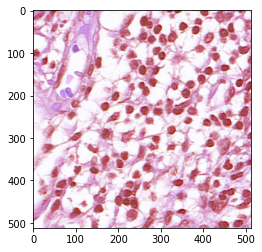

In [18]:
from matplotlib import pyplot as plt

plt.imshow(temp_origin)
plt.show()

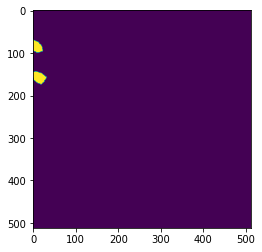

In [7]:
plt.imshow(gan.loaded_data[1][0])
plt.show()

In [5]:
from glob import glob

images = glob("C:\\Users\\gr300\\Desktop\\Works\의료데이터\\Level_0_512_random_Split\\FOLD_1\\wo_SN\\slide-2020-04-22T09-53-31-R3-S20\\image_MONO_random\\*")

print(len(images))

50


In [10]:
import cv2
import numpy as np
def imread(path):
    stream = open(path.encode("utf-8"), "rb")
    bytes = bytearray(stream.read())
    numpyArray = np.asarray(bytes, dtype=np.uint8)

    return cv2.imdecode(numpyArray, cv2.IMREAD_UNCHANGED)

In [13]:
img = imread(images[0]).shape

In [14]:
import matplotlib.pyplot as plt
import cv2
import numpy as np

index = 5
image_grayscale = img[:,:,:]
image_grayscale = np.flip(image_grayscale,axis=0)

width = 120
heigth = 40
data = image_grayscale
print(data.shape)

# Limits for the extent
x_start = 0
x_end = 120
y_start = 0
y_end = 40

extent = [x_start, x_end, y_start, y_end]

# The normal figure
fig = plt.figure(figsize=(16*5, 12*5))

ax2 = fig.add_subplot(211)
im = ax2.imshow(data, extent=extent, origin='lower', interpolation='None', cmap='Greys')

# Add the text
jump_x = (x_end - x_start) / (2.0 * width)
jump_y = (y_end - y_start) / (2.0 * heigth)
x_positions = np.linspace(start=x_start, stop=x_end, num=width, endpoint=False)
y_positions = np.linspace(start=y_start, stop=y_end, num=heigth, endpoint=False)

for y_index, y in enumerate(y_positions):
    for x_index, x in enumerate(x_positions):
        label = data[y_index, x_index]
        text_x = x + jump_x
        text_y = y + jump_y
        ax2.text(text_x, text_y, label, color='black', ha='center', va='center',size = 30)
plt.show()

TypeError: tuple indices must be integers or slices, not tuple